In [65]:
train = np.array(pd.read_csv('/Users/tommy84729/python/ML_HW3/x_train.csv', header = None))
train_t = np.array(pd.read_csv('/Users/tommy84729/python/ML_HW3/t_train.csv', header = None))
train_t = train_t.reshape(-1)

In [166]:
import numpy as np 
import pandas as pd
import stackprinter 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from collections import Counter

In [8]:
stackprinter.set_excepthook(style='darkbg2')

## 1. Analyze the difference between two decision approaches. Decide which one you want to use and explain why you choose this approach.

## 2. In order to visualize the result easily, you need to use the principal component analysis (PCA) to reduce the dimension of the data to 2 dimension

In [51]:
def eigenvector(eig_pairs, d) : 
    w_pca = np.array([])
    for i in range(d) : 
        w_pca = np.append(w_pca,eig_pairs[i][1])
    w_pca = np.array(w_pca.reshape(d, -1).T, dtype = 'float32')
    return w_pca

def pca(data, d) : 
    cov = np.cov(data.T)
    eig_val, eig_vec = np.linalg.eig(cov)
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    w_pca = eigenvector(eig_pairs, d)
    return w_pca

In [52]:
w_pca = pca(train, 2)

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [74]:
train_pca = train@w_pca

In [78]:
for i in range(2) : 
    train_pca[ : , i] = (train_pca[ : , i] - np.mean(train_pca[ : , i]))/np.std(train_pca[ : , i])
train_pca

2.3684757858670008e-17

## 3. Build a SVM with linear kernel to do multi-class classification. Then plot the corresponding decision boundary and support vectors. 

In [118]:
class_label = [(0, 1), (0, 2), (1, 2)]
index_0 = np.where(train_t == 0)
index_1 = np.where(train_t == 1)
index_2 = np.where(train_t == 2)
def index_class(x) : 
    target_dict = {}
    target_dict[(0, 1)] = np.concatenate((np.ones(100), np.full([100], -1), np.zeros(100)))
    target_dict[(0, 2)] = np.concatenate((np.ones(100), np.zeros(100), np.full([100], -1)))
    target_dict[(1, 2)] = np.concatenate((np.zeros(100), np.ones(100), np.full([100], -1)))
    
    multiplier = np.zeros([len(x), 2])
    multiplier[svm_index] = coef.T 

    multiplier_dict = {}
    multiplier_dict[(0, 1)] = np.concatenate((multiplier[:200, 0], np.zeros(100)))
    multiplier_dict[(0, 2)] = np.concatenate((multiplier[:100, 1], np.zeros(100), multiplier[200:, 0]))
    multiplier_dict[(1, 2)] = np.concatenate((np.zeros(100), multiplier[100:, 1]))
    return target_dict, multiplier_dict

    

In [120]:
def get_w_b(a, t, x):
        at = a*t
        w = at.dot(x)
        M_index = np.where(((a > 0) & (a < 1)))[0]
        S_index = np.nonzero(a)[0]
        Nm = len(M_index)
        if Nm == 0:
            b = -1 
        else:
            b = np.sum(t[M_index]) - np.sum(np.linalg.multi_dot([at[S_index], x[S_index], x[M_index].T]))
            b /= Nm
        return w, b
    
def predict(W, B, X, label):
    p = np.empty(len(X))
    for i in range(len(X)):
        candidate = []
        for w, b, lb in zip(W, B, label):
            y = w.dot(X[i]) + b
            if y > 0:
                candidate.append(lb[0])
            else:
                candidate.append(lb[1])
        p[i] = Counter(candidate).most_common(1)[0][0]

    return p

In [100]:
def make_meshgrid(x, y, h=.02):
    
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [171]:
clf1 = SVC(kernel = 'linear', decision_function_shape= 'ovo')
clf2 = SVC(kernel = 'poly', degree = 2, decision_function_shape = 'ovo')

In [172]:
clf1.fit(train_pca, train_t)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [173]:
coef = np.abs(clf1.dual_coef_)  # get alpha
svm_index = clf1.support_  # get support vector index

In [174]:
target_t, multiplier_a = index_class(train_pca)
t1 = target_t[(0,1)]
t2 = target_t[(0,2)]
t3 = target_t[(1,2)]
a1 = multiplier_a[(0,1)]
a2 = multiplier_a[(0,2)]
a3 = multiplier_a[(1,2)]

In [175]:
w1, b1 = get_w_b(a1, t1, train_pca)
w2, b2 = get_w_b(a2, t2, train_pca)
w3, b3 = get_w_b(a3, t3, train_pca)

X0, X1 = train_pca[:, 0], train_pca[:, 1]
xx, yy = make_meshgrid(X0, X1)

Z = predict((w1, w2, w3), (b1, b2, b3), np.c_[xx.ravel(), yy.ravel()], class_label)
Z = Z.reshape(xx.shape)

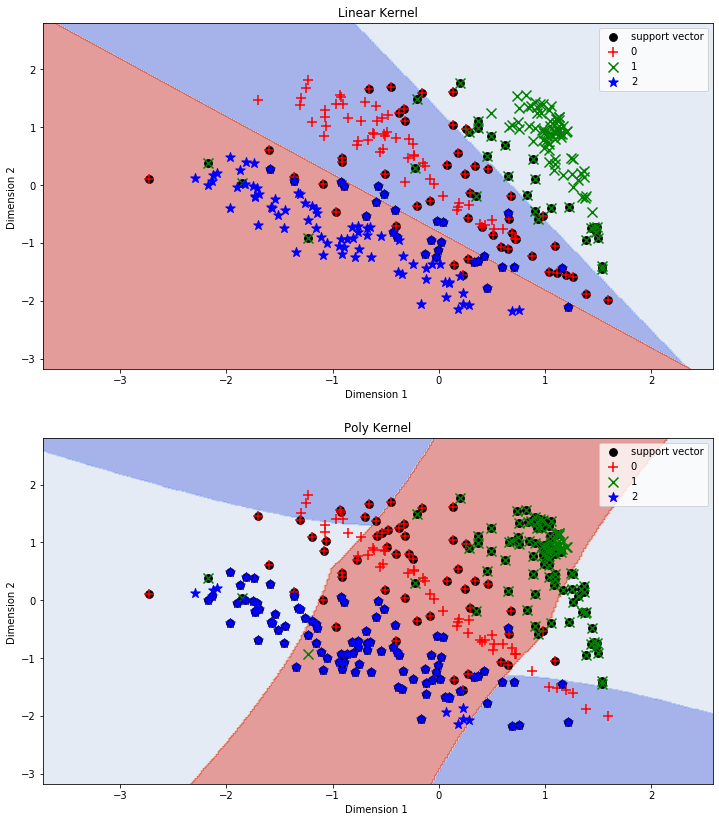

In [176]:
fig, sub = plt.subplots(2, figsize=(12, 14))
sub[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
sub[0].scatter(X0[svi], X1[svi], c='black', s=60, label='support vector')
sub[0].scatter(X0[index_0], X1[index_0], c='r', s=100, marker='+', label='0')
sub[0].scatter(X0[index_1], X1[index_1], c='g', s=100, marker='x', label='1')
sub[0].scatter(X0[index_2], X1[index_2], c='b', s=100, marker='*', label='2')
sub[0].legend()
sub[0].set_xlim(xx.min(), xx.max())
sub[0].set_ylim(yy.min(), yy.max())
sub[0].set_xlabel('Dimension 1 ')
sub[0].set_ylabel('Dimension 2 ')
sub[0].set_title('Linear Kernel')


clf2.fit(train_pca, train_t)

poly_x = np.vstack((train_pca[:, 0]**2, np.sqrt(2)*train_pca[:, 0]*train_pca[:, 1], train_pca[:, 1]**2)).T
coef = np.abs(clf2.dual_coef_)   #get alpha
svm_index = clf2.support_              #get support vector index

w1, b1 = get_w_b(a1, t1, poly_x)
w2, b2 = get_w_b(a2, t2, poly_x)
w3, b3 = get_w_b(a3, t3, poly_x)

Z = predict((w1, w2, w3), (b1, b2, b3),
            np.vstack((xx.ravel()**2, np.sqrt(2)*xx.ravel()*yy.ravel(), yy.ravel()**2)).T, class_label)
Z = Z.reshape(xx.shape)
sub[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
sub[1].scatter(X0[svm_index], X1[svm_index], c='black', s=60, label='support vector')
sub[1].scatter(X0[index_0], X1[index_0], c='r', s=100, marker='+', label='0')
sub[1].scatter(X0[index_1], X1[index_1], c='g', s=100, marker='x', label='1')
sub[1].scatter(X0[index_2], X1[index_2], c='b', s=100, marker='*', label='2')
sub[1].legend()
sub[1].set_xlim(xx.min(), xx.max())
sub[1].set_ylim(yy.min(), yy.max())
sub[1].set_xlabel('Dimension 1 ')
sub[1].set_ylabel('Dimension 2 ')
sub[1].set_title('Poly Kernel')
plt.show()